#### Soil Image Classification using RESNET

In [46]:
import os
import shutil
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [48]:
# Set random seeds for reproducibility
random.seed(42)
torch.manual_seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [50]:
# Define paths
base_dir = r'C:/Users/Harshith Y/Desktop/soil_images'  # Replace with your actual path
output_dir = r'C:/Users/Harshith Y/Desktop/soil'  # Where train/test will be created

In [52]:
# Step 1: Preprocessing and Train-Test Split
def prepare_dataset(base_dir, output_dir, test_size=0.2):
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)  # Clear previous split if exists
    
    os.makedirs(output_dir, exist_ok=True)
    for split in ['train', 'test']:
        os.makedirs(os.path.join(output_dir, split), exist_ok=True)
    
    # Classes
    classes = ['Red', 'Black', 'Alluvial', 'Laterite']
    
    for class_name in classes:
        class_path = os.path.join(base_dir, class_name)
        print(f"Checking path: {class_path}")  # Debug
        if not os.path.exists(class_path):
            raise FileNotFoundError(f"Directory not found: {class_path}")
        images = os.listdir(class_path)
        images = [os.path.join(class_path, img) for img in images if img.endswith(('.jpg', '.png', '.jpeg'))]
        
        # Split into train and test
        train_imgs, test_imgs = train_test_split(images, test_size=test_size, random_state=42)
        
        # Create class folders in train/test
        for split, img_list in [('train', train_imgs), ('test', test_imgs)]:
            split_class_dir = os.path.join(output_dir, split, class_name)
            os.makedirs(split_class_dir, exist_ok=True)
            for img in img_list:
                shutil.copy(img, split_class_dir)

In [54]:
# Step 2: Data Transformations (Enhanced Augmentation)
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [56]:
# Step 3: Load and Split Dataset
prepare_dataset(base_dir, output_dir, test_size=0.2)

image_datasets = {
    'train': datasets.ImageFolder(os.path.join(output_dir, 'train'), transform=data_transforms['train']),
    'test': datasets.ImageFolder(os.path.join(output_dir, 'test'), transform=data_transforms['test'])
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=4),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4)
}

# Dataset sizes and class names
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes
print(f"Class names: {class_names}")
print(f"Train size: {dataset_sizes['train']}, Test size: {dataset_sizes['test']}")

Checking path: C:/Users/Harshith Y/Desktop/soil_images\Red
Checking path: C:/Users/Harshith Y/Desktop/soil_images\Black
Checking path: C:/Users/Harshith Y/Desktop/soil_images\Alluvial
Checking path: C:/Users/Harshith Y/Desktop/soil_images\Laterite
Class names: ['Alluvial', 'Black', 'Laterite', 'Red']
Train size: 139, Test size: 35


In [58]:
# Step 4: Load and Modify ResNet-50
model = models.resnet50(pretrained=True)

# Unfreeze layer4 and fc for fine-tuning
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Modify the final fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))  # 4 classes
model = model.to(device)

# Loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

C:\Users\Harshith Y\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Harshith Y\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [60]:
# Step 5: Training Function with Scheduler
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    train_losses = []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        model.train()
        running_loss = 0.0
        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / dataset_sizes['train']
        train_losses.append(epoch_loss)
        print(f'Train Loss: {epoch_loss:.4f}')
        scheduler.step()  # Adjust learning rate
    
    # Plot training loss
    plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()
    plt.show()
    
    return model

In [62]:
# Step 6: Evaluation Function
def evaluate_model(model):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    print("Confusion Matrix:")
    print(cm)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
    plt.show()
    
    return accuracy

Starting training...
Epoch 1/20
Train Loss: 1.2924
Epoch 2/20
Train Loss: 0.8049
Epoch 3/20
Train Loss: 0.5358
Epoch 4/20
Train Loss: 0.4217
Epoch 5/20
Train Loss: 0.3052
Epoch 6/20
Train Loss: 0.2138
Epoch 7/20
Train Loss: 0.2333
Epoch 8/20
Train Loss: 0.2993
Epoch 9/20
Train Loss: 0.1900
Epoch 10/20
Train Loss: 0.2409
Epoch 11/20
Train Loss: 0.2340
Epoch 12/20
Train Loss: 0.2289
Epoch 13/20
Train Loss: 0.2166
Epoch 14/20
Train Loss: 0.1937
Epoch 15/20
Train Loss: 0.1868
Epoch 16/20
Train Loss: 0.2496
Epoch 17/20
Train Loss: 0.1645
Epoch 18/20
Train Loss: 0.2034
Epoch 19/20
Train Loss: 0.2217
Epoch 20/20
Train Loss: 0.2128


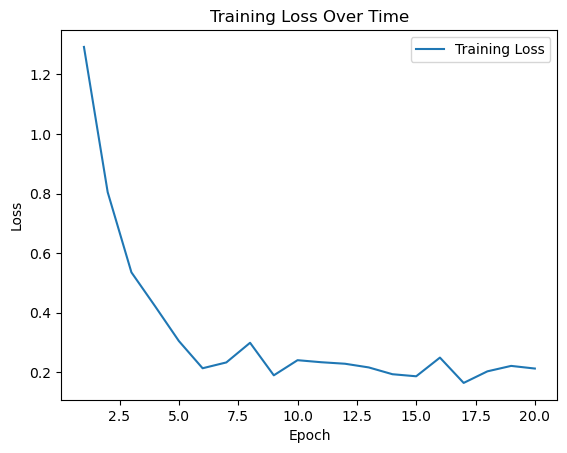


Evaluating model...
Test Accuracy: 80.00%
Confusion Matrix:
[[5 1 2 0]
 [1 8 0 0]
 [0 0 9 0]
 [0 0 3 6]]


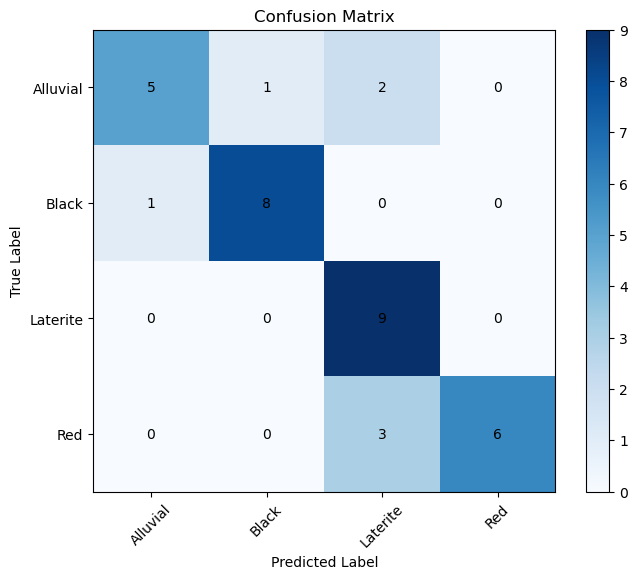

In [64]:
# Step 7: Train and Evaluate
print("Starting training...")
model = train_model(model, criterion, optimizer, scheduler, num_epochs=20)
print("\nEvaluating model...")
accuracy = evaluate_model(model)

In [101]:
# Step 8: Save the model
torch.save(model.state_dict(), 'C:/Users/Harshith Y/Desktop/soil_resnet50_complete.pth')
print("Model saved as 'soil_resnet50_complete.pth'")

Model saved as 'soil_resnet50_complete.pth'


#### Soil Image Classification using CNN-ALEXNET

In [31]:
import os
import shutil
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [33]:
# Set random seeds for reproducibility
random.seed(42)
torch.manual_seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [35]:
# Define paths
base_dir = r'C:/Users/Harshith Y/Desktop/soil_images'  # Replace with your actual path
output_dir = r'C:/Users/Harshith Y/Desktop/alexnet'  # Where train/test will be created

In [37]:
# Step 1: Preprocessing and Train-Test Split
def prepare_dataset(base_dir, output_dir, test_size=0.2):
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)  # Clear previous split if exists
    
    os.makedirs(output_dir, exist_ok=True)
    for split in ['train', 'test']:
        os.makedirs(os.path.join(output_dir, split), exist_ok=True)
    
    # Classes
    classes = ['Red', 'Black', 'Alluvial', 'Laterite']
    
    for class_name in classes:
        class_path = os.path.join(base_dir, class_name)
        print(f"Checking path: {class_path}")  # Debug
        if not os.path.exists(class_path):
            raise FileNotFoundError(f"Directory not found: {class_path}")
        images = os.listdir(class_path)
        images = [os.path.join(class_path, img) for img in images if img.endswith(('.jpg', '.png', '.jpeg'))]
        
        # Split into train and test
        train_imgs, test_imgs = train_test_split(images, test_size=test_size, random_state=42)
        
        # Create class folders in train/test
        for split, img_list in [('train', train_imgs), ('test', test_imgs)]:
            split_class_dir = os.path.join(output_dir, split, class_name)
            os.makedirs(split_class_dir, exist_ok=True)
            for img in img_list:
                shutil.copy(img, split_class_dir)

In [39]:
# Step 2: Data Transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),  # AlexNet expects 224x224
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet stats
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [41]:
# Step 3: Load and Split Dataset
prepare_dataset(base_dir, output_dir, test_size=0.2)

image_datasets = {
    'train': datasets.ImageFolder(os.path.join(output_dir, 'train'), transform=data_transforms['train']),
    'test': datasets.ImageFolder(os.path.join(output_dir, 'test'), transform=data_transforms['test'])
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=4),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4)
}
# Dataset sizes and class names
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes
print(f"Class names: {class_names}")
print(f"Train size: {dataset_sizes['train']}, Test size: {dataset_sizes['test']}")

Checking path: C:/Users/Harshith Y/Desktop/soil_images\Red
Checking path: C:/Users/Harshith Y/Desktop/soil_images\Black
Checking path: C:/Users/Harshith Y/Desktop/soil_images\Alluvial
Checking path: C:/Users/Harshith Y/Desktop/soil_images\Laterite
Class names: ['Alluvial', 'Black', 'Laterite', 'Red']
Train size: 139, Test size: 35


In [43]:
# Step 4: Load and Modify AlexNet
model = models.alexnet(pretrained=True)

# Modify the classifier for 4 classes (AlexNet's classifier is a Sequential module)
model.classifier[6] = nn.Linear(4096, len(class_names))  # Replace the last layer (originally 1000 classes)
model = model.to(device)

# Loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Fine-tune all layers
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

C:\Users\Harshith Y\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Harshith Y\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [45]:
# Step 5: Training Function with Scheduler
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    train_losses = []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        model.train()
        running_loss = 0.0
        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / dataset_sizes['train']
        train_losses.append(epoch_loss)
        print(f'Train Loss: {epoch_loss:.4f}')
        scheduler.step()  # Adjust learning rate
    
    # Plot training loss
    plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()
    plt.show()
    
    return model

In [49]:
# Step 6: Evaluation Function
def evaluate_model(model):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    print("Confusion Matrix:")
    print(cm)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    pltrichment = cm, interpolation='nearest'
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
    plt.show()
    
    return accuracy

Starting training with AlexNet...
Epoch 1/20
Train Loss: 1.3392
Epoch 2/20
Train Loss: 0.6752
Epoch 3/20
Train Loss: 0.5234
Epoch 4/20
Train Loss: 0.3518
Epoch 5/20
Train Loss: 0.3309
Epoch 6/20
Train Loss: 0.2543
Epoch 7/20
Train Loss: 0.2679
Epoch 8/20
Train Loss: 0.1930
Epoch 9/20
Train Loss: 0.2664
Epoch 10/20
Train Loss: 0.2445
Epoch 11/20
Train Loss: 0.2006
Epoch 12/20
Train Loss: 0.2172
Epoch 13/20
Train Loss: 0.2339
Epoch 14/20
Train Loss: 0.1644
Epoch 15/20
Train Loss: 0.2580
Epoch 16/20
Train Loss: 0.2469
Epoch 17/20
Train Loss: 0.1872
Epoch 18/20
Train Loss: 0.2308
Epoch 19/20
Train Loss: 0.2061
Epoch 20/20
Train Loss: 0.2517


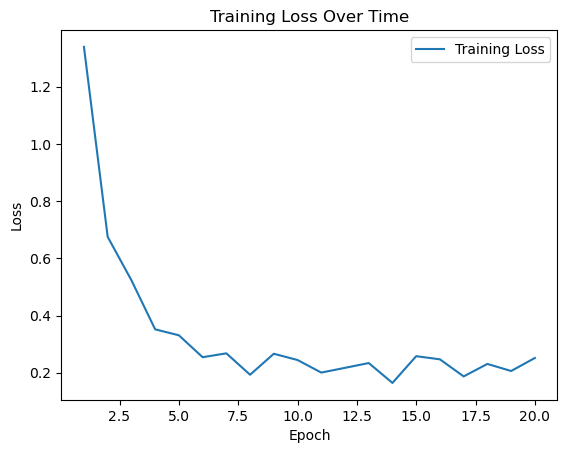


Evaluating model...
Test Accuracy: 74.29%
Confusion Matrix:
[[7 0 1 0]
 [3 6 0 0]
 [1 0 8 0]
 [0 0 4 5]]


ValueError: too many values to unpack (expected 2)

<Figure size 800x600 with 0 Axes>

In [51]:
# Step 7: Train and Evaluate
print("Starting training with AlexNet...")
model = train_model(model, criterion, optimizer, scheduler, num_epochs=20)
print("\nEvaluating model...")
accuracy = evaluate_model(model)

In [53]:
# Step 8: Save the model
torch.save(model.state_dict(), 'C:/Users/Harshith Y/Desktop/soil_alexnet.pth')
print("Model saved as 'soil_alexnet.pth'")

Model saved as 'soil_alexnet.pth'
